Close Figures' 1 - 2 windows to continue...


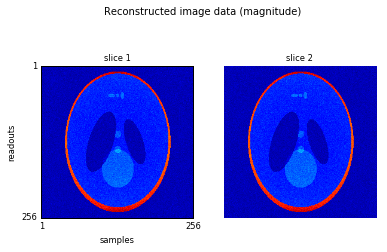

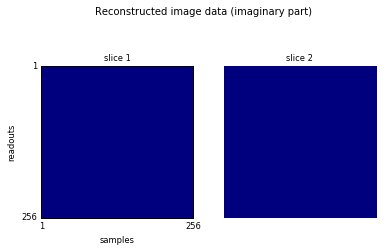

writing to Gfs_long.h5
Close Figure 1 window to continue...


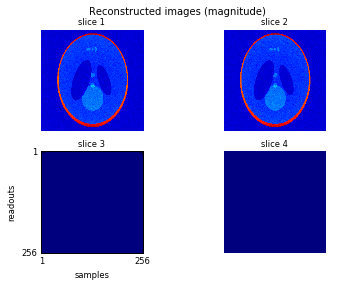

In [2]:
#  '''
#Medium-level interface demo that illustrates 2D Cartesian MR image 
#reconstruction using Gadgetron by directly creating and running a chain of 
#gadgets.
#
#Usage:
#  fully_sampled_recon_single_chain.py [--help | options]
#
#Options:
# -f <file>, --file=<file>    raw data file
#                              [default: simulated_MR_2D_cartesian.h5]
#  -p <path>, --path=<path>    path to data files, defaults to data/examples/MR
#                              subfolder of SIRF root folder
#  -o <file>, --output=<file>  images output file
#'''
#
## CCP PETMR Synergistic Image Reconstruction Framework (SIRF).
## Copyright 2015 - 2017 Rutherford Appleton Laboratory STFC.
## Copyright 2015 - 2017 University College London.
## Copyright 2015 - 2017 Physikalisch-Technische Bundesanstalt.
##
## This is software developed for the Collaborative Computational
## Project in Positron Emission Tomography and Magnetic Resonance imaging
## (http://www.ccppetmr.ac.uk/).
##
## Licensed under the Apache License, Version 2.0 (the "License");
##   you may not use this file except in compliance with the License.
##   You may obtain a copy of the License at
##       http://www.apache.org/licenses/LICENSE-2.0
##   Unless required by applicable law or agreed to in writing, software
##   distributed under the License is distributed on an "AS IS" BASIS,
##   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
##   See the License for the specific language governing permissions and
##   limitations under the License.

__version__ = '0.1.0'
from docopt import docopt

import time

# import engine module
from pGadgetron import *

# process command-line options
data_file = 'simulated_MR_2D_cartesian.h5' 
data_path = petmr_data_path('mr')
output_file = 'Gfs_long.h5'


# locate the input data
input_file = existing_filepath(data_path, data_file)
acq_data = AcquisitionData(input_file)
    
# create reconstruction object
# Rather than using a predefined image reconstruction object, here a new 
# image reconstruction object is created by concatinating multiple gadgets 
# (for more information on Gadgetron and its gadgets please see: # https://github.com/gadgetron/.).
# Parameters for individual gadgets can be defined either during the 
# creation of the reconstruction object:
#   e.g. AcquisitionAccumulateTriggerGadget(trigger_dimension=repetition)
# or by giving a gadget a label (cf. label ex: for the last gadget)
# and using set_gadget_property(label, propery, value).
# The gadgets will be concatenated and will be executed as soon as 
# process() is called.
recon = Reconstructor(['RemoveROOversamplingGadget', \
    'AcquisitionAccumulateTriggerGadget(trigger_dimension=repetition)', \
    'BucketToBufferGadget(split_slices=true, verbose=false)', \
    'SimpleReconGadget', 'ImageArraySplitGadget', 'ex:ExtractGadget'])
        
# ExtractGadget defines which type of image should be returned:
# none      0
# magnitude 1
# real      2
# imag      4
# phase     8
# max       16  
# in this example '5' returns both magnitude and imag    
recon.set_gadget_property('ex', 'extract_mask', 5) 
    
# provide raw k-space data as input
recon.set_input(acq_data)
    
# perform reconstruction
recon.process()
    
# retrieve reconstructed image data
image_data = recon.get_output()

# show reconstructed image data
image_array = image_data.as_array()
title = 'Reconstructed image data (magnitude)'
%matplotlib inline

show_3D_array(abs(image_array[0::2,:,:]), suptitle = title, \
                xlabel = 'samples', ylabel = 'readouts', label = 'slice', \
                 show = False)
title = 'Reconstructed image data (imaginary part)'
show_3D_array(image_array[1::2,:,:].imag, suptitle = title, \
                xlabel = 'samples', ylabel = 'readouts', label = 'slice' )
#                cmap = 'gray')

if output_file is not None:
    # write images to a new group in args.output
    # named after the current date and time
    time_str = time.asctime()
    print('writing to %s' % output_file)
    image_data.write(output_file, time_str)

    saved_image_data = ImageData(output_file)
    image_array = saved_image_data.as_array()
    title = 'Reconstructed images (magnitude)'
    show_3D_array(abs(image_array), suptitle = title, \
                    xlabel = 'samples', ylabel = 'readouts', label = 'slice' )
#                    cmap = 'gray')
    
    